In [1]:
import heeps
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.pupil.create_lyotstop import create_ls
from heeps.util.img_processing import resize_img, pad_img, crop_img, oversamp
from heeps.util.round2 import round2odd
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper.prop_get_amplitude as get_amplitude
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import astropy.units as u
from photutils import CircularAperture, aperture_photometry
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import warnings
%matplotlib inline

### Inputs

In [2]:
pupil_img_size = 39.9988    # pupil image in m
nimg = 10526                # size of the high-res pupil image
print('pupil_img_size = %s m'%pupil_img_size)
print('nimg = %s'%nimg)
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# RAVC params
diam_ravc_opt = 19.154
ravc_t = 0.7909
ravc_r = 0.5190
# spider width in m
spi_width = 0.54
# 2D map
npup = 41
nspi = 41
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# METIS "pupil image" size in mm
pupil_img_size_METIS = {'IMG': 45/diam_nominal_ext*pupil_img_size, 
                        'LMS': 28/diam_nominal_ext*pupil_img_size}
print('pupil_img_size_METIS = %s mm'%dict((x, round(y, 2)) 
    for x, y in pupil_img_size_METIS.items()))
# Huygens PSF data
dir_data = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/pupil_blurring/data'))
nkernel = 127
data_spacing = 0.014239     # in mm
samp = dict((x, oversamp(nimg, y/data_spacing, precision=1e-2, to_odd=True))
    for x, y in pupil_img_size_METIS.items())
nimg_pad = dict((x, y[0]) for x, y in samp.items())
npup_conv = dict((x, y[1]) for x, y in samp.items())
print('nimg = %s'%nimg)
print('nimg_pad = %s'%nimg_pad)
print('npup_conv = %s'%npup_conv)
# parameters at each band
phot_spiders = {'L' :3.5,   # pixels on the spiders (for 1 inside the pupil)
                'N2':4.3}
phot_envirnt = {'L' :4.3,   # pixels outside the pupil (for 1 inside the pupil)
                'N2':5.1}
npupil = {'L': update_config(**dict(read_config(), band='L'))['npupil'],
          'N2':update_config(**dict(read_config(), band='N2'))['npupil']}
pupil_scaling = 4
print('npupil = %s'%npupil)
print('pupil_scaling = %s'%pupil_scaling)
title_bkg = 'Relative additionnal background'
title_app = 'APP flux uniformity'
title_vpm = 'Relative additionnal VPM leakage'
title_vpm2 = 'VPM leakage'
title_vpm3 = 'VPM leakage/thruput^2'

pupil_img_size = 39.9988 m
nimg = 10526
pupil_img_size_METIS = {'IMG': 46.7, 'LMS': 29.06} mm
nimg = 10526
nimg_pad = {'IMG': 10562, 'LMS': 10682}
npup_conv = {'IMG': 3291, 'LMS': 2071}
npupil = {'L': 285, 'N2': 119}
pupil_scaling = 4


### Create pupils

In [3]:
eso = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil/eso'))
maskM1 = fits.getdata(os.path.join(eso, 'mask_fullM1.fits'))
spiders = fits.getdata(os.path.join(eso, 'SpiderShadow.fits'))
pickle_M1 = os.path.join(eso, 'pup_M1.pkl')
if os.path.isfile(pickle_M1):
    pup_M1 = pickle.load(open(pickle_M1,'rb'))
else:
    pup_M1 = dict((x, resize_img(pad_img(maskM1*spiders, y), z))
                for (x, y), (x, z) in zip(nimg_pad.items(), npup_conv.items()))
    with open(pickle_M1, 'wb') as file:
        pickle.dump(pup_M1, file)
        file.close()
pickle_bkg = os.path.join(eso, 'pup_bkg.pkl')
if os.path.isfile(pickle_bkg):
    pup_bkg = pickle.load(open(pickle_bkg,'rb'))
else:
    pup_bkg = dict((x, dict((band, resize_img(pad_img(maskM1*((1 - spiders)*phot_spi) 
                    + (1 - maskM1)*phot_env, y), z)) 
                    for (band, phot_spi), (band, phot_env) 
                    in zip(phot_spiders.items(), phot_envirnt.items())))
                for (x, y), (x, z) in zip(nimg_pad.items(), npup_conv.items()))
    with open(pickle_bkg, 'wb') as file:
        pickle.dump(pup_bkg, file)
        file.close()

### Define functions

In [4]:
def conf_init(dir_output, band, mode):
    # initialize conf for HEEPS
    conf = dict(
        dir_output = 'output_files/pupil_blurring/' + dir_output,
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = band,
        mode = mode,
        ravc_calc = False,
        )
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
    return conf

def conv_pupil(conf, plane, data, i, geometric_spacing=0.0004):
    band = conf['band']
    filename = conf['dir_output'] + 'data_%s_npad_vpm.fits'%i
    if os.path.isfile(filename):
        kernel = fits.getdata(conf['dir_output'] + 'data_%s_kernel.fits'%i)
        pup_bkg_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i)
        pup_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_conv.fits'%i)
        kernel_vpm = fits.getdata(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i)
        pup_vpm = fits.getdata(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i)
        npad_vpm = fits.getdata(conf['dir_output'] + 'data_%s_npad_vpm.fits'%i)[0]
        nkernel_vpm = kernel_vpm.shape[0]
        npup_vpm = pup_vpm.shape[0]
    else:
        # 1/ load kernel (Huygens PSF)
        if 'geometric' in data:
            pad_kernel = round(nkernel*data_spacing/geometric_spacing)
            kernel = np.loadtxt(data%i , delimiter='\t', skiprows=5)[1:,1:]
            kernel /= np.max(kernel)
            kernel = resize_img(pad_img(kernel, pad_kernel), nkernel)
        else:
            kernel = np.loadtxt(data%i, delimiter='\t', encoding='utf-16', skiprows=21)[1:,1:]
        # 2/ convolve background thermal emission with kernel
        if 'geometric' in data:
            pup_bkg_conv = np.array([[0]])
        else:
            pup_bkg_conv = astroconv.convolve(pup_bkg[plane][band], kernel, boundary='extend')
        # 3/ convolve M1 pupil with kernel
        pup_conv = astroconv.convolve(pup_M1[plane], kernel, boundary='extend')
        # 4/ resample kernel
        nkernel_vpm = round2odd(nkernel*pupil_scaling*npupil[band]/npup_conv[plane])
        npup_vpm = npup_conv[plane]*nkernel_vpm/nkernel
        npad_vpm, npup_vpm = oversamp(nimg, npup_vpm, precision=1e-2, to_odd=True)
        kernel_vpm = resize_img(kernel, nkernel_vpm)
        pup_vpm = resize_img(pad_img(maskM1*spiders, npad_vpm), npup_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel.fits'%i, kernel)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i, pup_bkg_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_conv.fits'%i, pup_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i, kernel_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i, pup_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_npad_vpm.fits'%i, np.array([npad_vpm]))
    print('background:')
    print('   nkernel = %s, npup_conv = %s'%(nkernel, npup_conv[plane]))
    print('HCI:')
    print('   nkernel_vpm = %s, npup_vpm = %s\n'%(nkernel_vpm, npup_vpm))
    # 5/ figure
    c = pup_conv.shape[0]/2
    cext = c/pupil_img_size*diam_allglass_ext
    cint = c/pupil_img_size*diam_allglass_int
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.1, 1, 1])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.subplot(gs[0]); plt.title('kernel (log10)')
        plt.imshow(np.log10(kernel), origin='lower', cmap='inferno')
        plt.colorbar(cax=fig.add_axes([0.33, 0.17, 0.01, 0.65]))
        vmin, vmax = -1, 1 #log10
        plt.subplot(gs[2]); plt.title('blurred background (log10)')
        plt.imshow(np.log10(pup_bkg_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[2].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[2].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
        plt.subplot(gs[3]); plt.title('blurred pupil (log10)')
        plt.imshow(np.log10(pup_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[3].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[3].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
    plt.colorbar(cax=fig.add_axes([0.85, 0.17, 0.01, 0.65]))
    plt.subplots_adjust(right=0.84) # for colorbar
    plt.savefig(conf['dir_output'] + 'data_%s_blurring.png'%i, dpi=300, transparent=True)
    return pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm

def cold_stop(conf, r_pup, r_spi, circ_int=False, dRint=0.08):
    # RAVC case (circ_int set to True)
    diam_int = diam_ravc_opt if circ_int == True else diam_allglass_int
    # CVC case (ls_dRint set to None)
    dRint = dRint if conf['ls_dRint'] is None else r_pup
    # create cold stop
    cs = create_ls(diam_allglass_ext, diam_int, dRext=r_pup, dRint=dRint, dRspi=r_spi,
                    circ_ext=False, circ_int=circ_int, **conf)
    return cs

def get_blur_sharp(conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2, r_pup, r_spi):
    # background case
    if pup_bkg_conv.shape != (0, 0):
        # flux from sharp background
        cs = cold_stop(conf, r_pup, r_spi)
        bkg_sharp = np.sum(cs)
        # relative flux from blurred background
        bkg_blur = np.sum(cs*pup_bkg_conv)/bkg_sharp
    elif 'APP' in conf['mode']:
        cs = cold_stop(conf, r_pup, r_spi)
    # HCI case
    I_blur, I_sharp = 0, 0
    if 'VC' in conf['mode']:
        if 'CVC' in conf['mode']:
            conf_vpm['ls_dRint'] = None
        # flux from sharp pupil
        cs_vpm = cold_stop(conf_vpm, r_pup, r_spi, circ_int=('RAVC' in conf['mode']))
        # sharp leakage
        I_sharp = np.sum((cs_vpm*amp1)**2)
        # blurred leakage
        I_blur = np.sum((cs_vpm*amp2)**2)
        # relative leakage from blurred pupil
        hci_blur = (I_blur/I_sharp) - 1
        hci_sharp = np.sum(cs_vpm)
    elif 'APP' in conf['mode']:
        # p2v flux from blurred pupil
        hci_sharp = bkg_sharp
        hci_blur = np.round(cs).astype(int)*pup_conv
        hci_blur = 1 - np.min(hci_blur[hci_blur!=0])
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm,
        i, rs, rp, plane='IMG'):
    filename = conf['dir_output'] + 'data_%s_hci_blur.fits'%i
    if os.path.isfile(filename):
        bkg_blur = fits.getdata(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i)
        bkg_sharp = fits.getdata(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i)
        hci_blur = fits.getdata(conf['dir_output'] + 'data_%s_hci_blur.fits'%i)
        hci_sharp = fits.getdata(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i)
        I_blur = fits.getdata(conf['dir_output'] + 'data_%s_I_blur.fits'%i)
        I_sharp = fits.getdata(conf['dir_output'] + 'data_%s_I_sharp.fits'%i)
    else:
        conf_vpm = deepcopy(conf)
        conf['npupil'] = pup_conv.shape[0]
        conf['pupil_img_size'] *= nimg_pad[plane]/nimg
        amp1, amp2 = 0, 0
        if 'VC' in conf['mode']:
            npupil_scaled = pupil_scaling*conf_vpm['npupil']
            conf_vpm['npupil'] = pup_vpm.shape[0]
            conf_vpm['ngrid'] *= pupil_scaling
            conf_vpm['pupil_img_size'] *= npad_vpm/nimg
            conf_vpm['pscale'] *= conf_vpm['npupil']/npupil_scaled*nimg/npad_vpm
            conf_vpm = heeps.config.update_config(**conf_vpm, verbose=True)
            wf = heeps.pupil.pupil(pup=pup_vpm, **conf_vpm, verbose=True)
            wf = heeps.optics.apodizer(wf, **conf_vpm, verbose=True)
            wf = heeps.optics.fp_mask(wf, **conf_vpm, verbose=True)
            amp1 = crop_img(get_amplitude(wf), conf_vpm['npupil'])
            amp2 = astroconv.convolve(amp1, kernel_vpm, boundary='extend')
        out1, out2, out3, out4, out5, out6 = multiCPU(get_blur_sharp, nout=4,
            posargs=[conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], verbose=True)
        bkg_blur = out1.reshape(npup, nspi)
        bkg_sharp = out2.reshape(npup, nspi)
        hci_blur = out3.reshape(npup, nspi)
        hci_sharp = out4.reshape(npup, nspi)
        I_blur = out5.reshape(npup, nspi)
        I_sharp = out6.reshape(npup, nspi)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i, bkg_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i, bkg_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_blur.fits'%i, hci_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i, hci_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_I_blur.fits'%i, I_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_I_sharp.fits'%i, I_sharp)
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def plot_2d_map(conf, blur, thruput, i, rs, rp, rs_opt, rp_opt, title):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        _, ax = plt.subplots(figsize = (8,6))
        plt.imshow(np.log10(blur), origin='lower', aspect='auto', 
                   cmap='viridis', extent=(rs[0],rs[-1],rp[0],rp[-1]))
        plt.plot(rs, rs, ':', color='white')
        plt.colorbar()
        f_blur = interp2d(rs, rp, blur)
        f_thruput = interp2d(rs, rp, thruput)
        optim = f_blur(rs_opt, rp_opt)
        def fmt(x):
            return '%.0e'%10**(x) if x % 1 == 0 else '%.2e'%10**(x)
        print('intersect = %s (%.2f%%, %.2f%%)'
            %(fmt(np.log10(optim)), rs_opt*100, rp_opt*100))

        cs_min = max(np.min(blur), 1e-6)
        cs_max = np.max(blur)
        cs_min = int(np.ceil(np.log10(cs_min)))
        cs_max = int(np.floor(np.log10(cs_max)))
        small_range = (cs_max <= cs_min)
        cs_range = np.arange(cs_min, cs_max + 1) if not small_range \
            else np.log10(np.logspace(np.log10(np.min(blur)*1.05), 
                                      np.log10(np.max(blur)/1.1), 5))
        cs_vals = np.append(np.log10(optim), cs_range)
        cs_ls = np.append(':', ['-']*(len(cs_vals) - 1))
        cs_ls = cs_ls[np.argsort(cs_vals)]
        cs_vals = np.sort(cs_vals)
        CS = ax.contour(np.log10(blur.clip(min=1e-7)), cs_vals, colors='magenta', linewidths=2, 
                linestyles=cs_ls, extent=(rs[0],rs[-1],rp[0],rp[-1]))
        lx = []
        ly = []
        for j,c in enumerate(CS.collections):
            v = c.get_paths()[0].vertices
            x = v[:,0]
            y = v[:,1]
            t = np.array([f_thruput(s,p) for s,p in zip(x,y)])
            k = np.argmax(t)
            plt.scatter(x[k], y[k], s=150, c='magenta', marker='+')
            lx.append(x[k]+7e-3)
            ly.append(y[k]-1e-3)
            print('optim %s = %s (%.2f%%, %.2f%%)'
                %(j, fmt(cs_vals[j]), x[k]*100, y[k]*100))

        if np.min(blur) < 1e-10 or small_range:
            ax.clabel(CS, CS.levels, fontsize=12, fmt=fmt)
        else:
            manual = np.array([lx,ly]).T
            ax.clabel(CS, CS.levels, fontsize=12, fmt=fmt, manual=manual)

        #plt.scatter(rs_opt, rp_opt, s=150, c='red', marker='+')
        plt.xlim(rs[0], rs[-1])
        plt.ylim(rp[0], rp[-1])
        plt.xlabel('ls_dRspi')
        if 'CVC' in conf['mode'] and 'VPM leakage' in title:
            plt.ylabel('ls_dRext')
        else:
            plt.ylabel('ls_dRext & ls_dRint')
        plt.title(title)
        #ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
        #ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
        tag = title.replace(' ', '_').replace('/', '_').replace('^', '')
        plt.savefig(conf['dir_output'] + 'data_%s_%s.png'
            %(i, tag), dpi=300, transparent=True)

def get_strehl(wf, conf, fwhm, r_pup, r_spi):
    cs = cold_stop(conf, r_pup, r_spi, circ_int=('RAVC' in conf['mode']))
    wf1 = heeps.optics.lyot_stop(deepcopy(wf), ls_mask=cs, **conf)
    psf = heeps.optics.detector(wf1, **conf)
    c = conf['ndet']//2
    aper = CircularAperture((c, c), r=fwhm/2)
    psf_flux = aperture_photometry(psf, aper)['aperture_sum'].data[0]
    psf_max = np.max(psf)
    return psf_flux, psf_max

def get_strehl_2d(mode, rs, rp):
    conf = dict(
        dir_output = 'output_files/pupil_blurring/Strehl',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        mode = mode,
        ravc_calc = False,
    )    
    conf = heeps.config.read_config(**conf)
    filename = conf['dir_output'] + '%s_strehl_flux.fits'%mode
    if os.path.isfile(filename):
        strehl_flux = fits.getdata(conf['dir_output'] + '%s_strehl_flux.fits'%mode)
        strehl_max = fits.getdata(conf['dir_output'] + '%s_strehl_max.fits'%mode)
    else:
        conf = heeps.config.update_config(**conf)
        if 'CVC' in conf['mode']:
            conf['ls_dRint'] = None
        wf = heeps.pupil.pupil(**conf)
        wf = heeps.optics.apodizer(wf, **conf)
        fwhm = conf['lam']/conf['diam_nominal']*u.rad.to('mas')/conf['pscale']
        out1, out2 = multiCPU(get_strehl, nout=2,
            posargs=[wf, conf, fwhm],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], verbose=True)
        strehl_flux = out1.reshape(npup, nspi)
        strehl_max = out2.reshape(npup, nspi)
        strehl_flux /= strehl_flux[0,0]
        strehl_max /= strehl_max[0,0]
        fits.writeto(conf['dir_output'] + '%s_strehl_flux.fits'%mode, strehl_flux)
        fits.writeto(conf['dir_output'] + '%s_strehl_max.fits'%mode, strehl_max)
    fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(strehl_flux, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.title('%s Strehl (PSF flux)'%mode)
    plt.xlabel('ls_dRspi')
    if 'CVC' in conf['mode']:
        plt.ylabel('ls_dRext')
    else:
        plt.ylabel('ls_dRext & ls_dRint')
    plt.subplot(1,2,2)
    plt.imshow(strehl_max, origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.title('%s Strehl (PSF max)'%mode)
    plt.xlabel('ls_dRspi')
    plt.colorbar(cax=fig.add_axes([0.85, 0.17, 0.01, 0.65]))
    plt.subplots_adjust(right=0.84) # for colorbar
    return strehl_flux, strehl_max

### VPM Strehl ratio

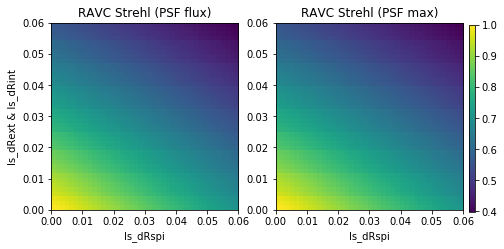

In [5]:
ravc_strehl_flux, ravc_strehl_max = get_strehl_2d('RAVC', rs, rp)

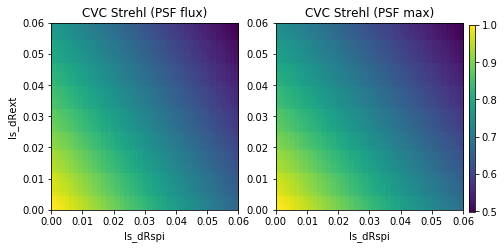

In [6]:
cvc_strehl_flux, cvc_strehl_max = get_strehl_2d('CVC', rs, rp)

# 1) APP + classical imaging (field = 10.85")

In [7]:
band = 'L'
mode = 'APP'

## 1.1) IMG plane

In [8]:
plane = 'IMG'
rs_opt = 0.0391#0.0517
rp_opt = 0.0391#0.0491

### with diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



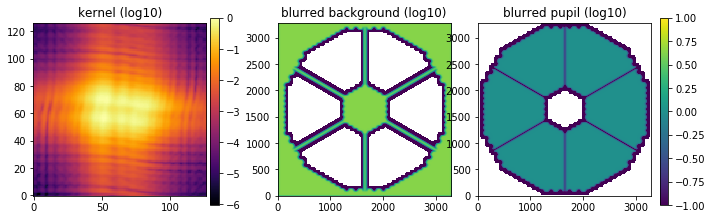

In [9]:
conf = conf_init('IMG_L_field_10.85_app', band, mode)
data = os.path.join(dir_data, 'IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [10]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 1.67e-05 (3.91%, 3.91%)
optim 0 = 1e-06 (4.20%, 5.11%)
optim 1 = 1e-05 (3.75%, 4.35%)
optim 2 = 1.67e-05 (3.75%, 4.00%)
optim 3 = 1e-04 (3.23%, 3.30%)
optim 4 = 1e-03 (2.14%, 2.25%)
optim 5 = 1e-02 (1.05%, 0.97%)


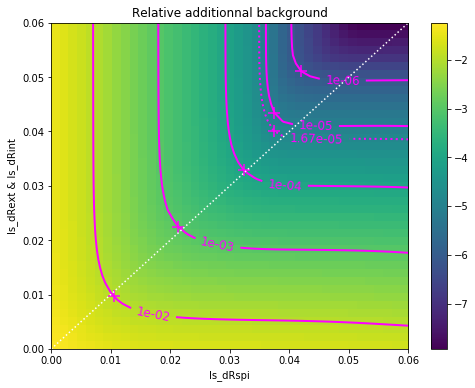

In [11]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 5.97e-03 (3.91%, 3.91%)
optim 0 = 1e-04 (3.98%, 5.40%)
optim 1 = 1e-03 (3.55%, 4.95%)
optim 2 = 5.97e-03 (2.71%, 4.05%)
optim 3 = 1e-02 (2.40%, 3.60%)
optim 4 = 1e-01 (1.35%, 2.39%)


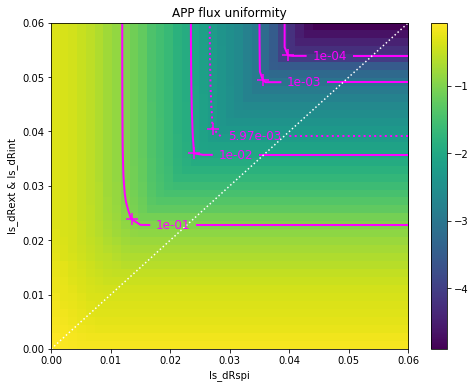

In [12]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_app)

### no diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



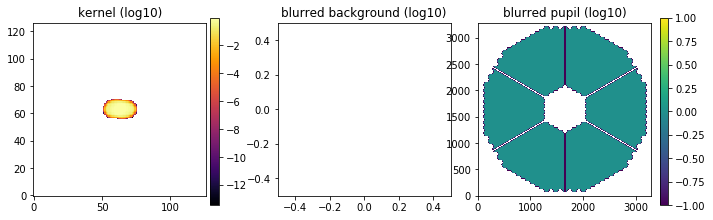

In [13]:
conf = conf_init('IMG_L_field_10.85_app_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [14]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 0.00e+00 (3.91%, 3.91%)
optim 0 = 0.00e+00 (0.69%, 1.95%)
optim 1 = 1e-06 (0.63%, 1.95%)
optim 2 = 1e-05 (0.58%, 1.80%)
optim 3 = 1e-04 (0.51%, 1.80%)
optim 4 = 1e-03 (0.45%, 1.62%)
optim 5 = 1e-02 (0.28%, 1.35%)


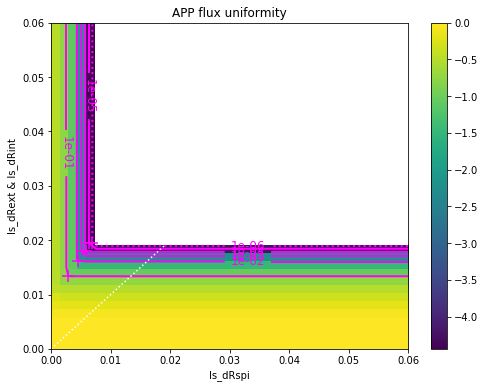

In [15]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_app)

## 1.2) LMS plane

In [16]:
plane = 'LMS'
rs_opt = 0.0225
rp_opt = 0.0225

### with diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



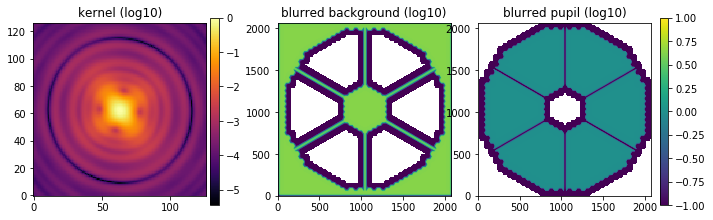

In [17]:
conf = conf_init('LMS_L_field_10.85_app', band, mode)
data = os.path.join(dir_data, 'LMS_3_worstcase_pp%s.txt')
data_i = 7
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [18]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 4.48e-03 (2.25%, 2.25%)
optim 0 = 1e-03 (4.20%, 4.14%)
optim 1 = 4.48e-03 (2.25%, 2.25%)
optim 2 = 1e-02 (1.20%, 1.29%)


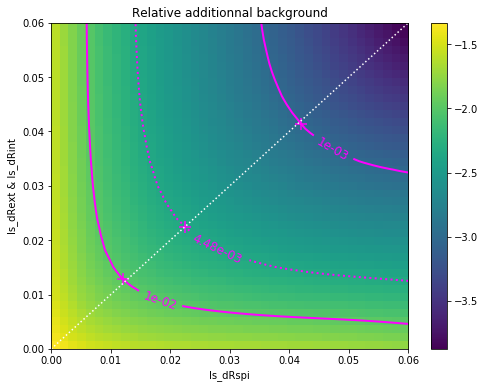

In [19]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 6.03e-02 (2.25%, 2.25%)
optim 0 = 1e-02 (3.57%, 4.50%)
optim 1 = 6.03e-02 (1.35%, 2.49%)
optim 2 = 1e-01 (1.05%, 2.03%)


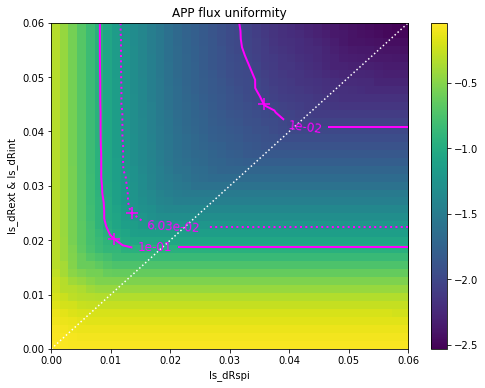

In [20]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_app)

### no diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



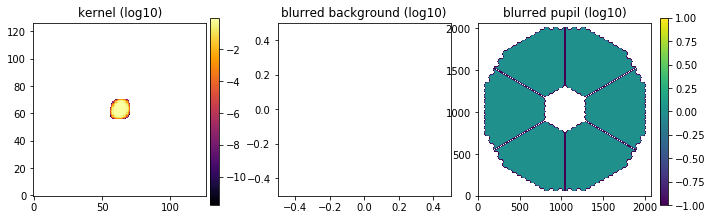

In [21]:
conf = conf_init('LMS_L_field_10.85_app_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/LMS_3_worstcase_pp%s.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [22]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 0.00e+00 (2.25%, 2.25%)
optim 0 = 0.00e+00 (0.74%, 1.95%)
optim 1 = 1e-06 (0.69%, 1.95%)
optim 2 = 1e-05 (0.64%, 1.95%)
optim 3 = 1e-04 (0.60%, 1.78%)
optim 4 = 1e-03 (0.59%, 1.65%)
optim 5 = 1e-02 (0.45%, 1.37%)


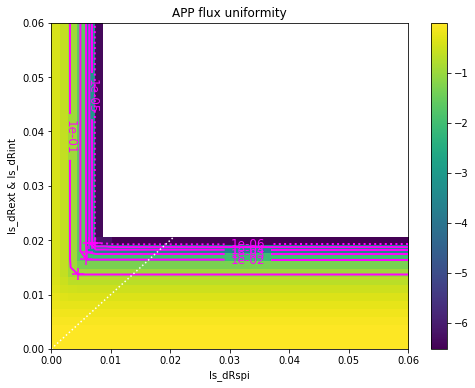

In [23]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_app)

### test longer wavelength

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



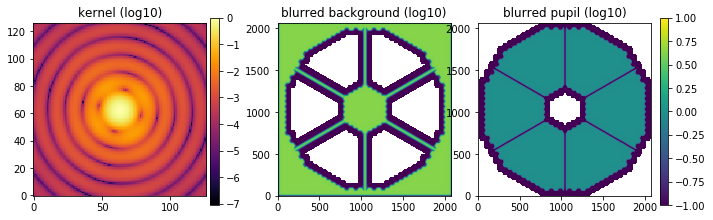

In [24]:
conf = conf_init('LMS_L_field_10.85_app_wl3', band, mode)
data = os.path.join(dir_data, 'LMS_3_worstcase_pp%s_wl3.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [25]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 5.43e-03 (2.25%, 2.25%)
optim 0 = 1e-03 (4.50%, 4.28%)
optim 1 = 5.43e-03 (2.25%, 2.25%)
optim 2 = 1e-02 (1.39%, 1.50%)


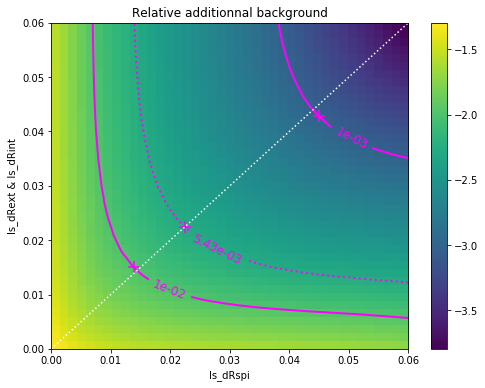

In [26]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 5.00e-02 (2.25%, 2.25%)
optim 0 = 1e-02 (3.90%, 4.79%)
optim 1 = 5.00e-02 (1.95%, 2.25%)
optim 2 = 1e-01 (1.05%, 2.00%)


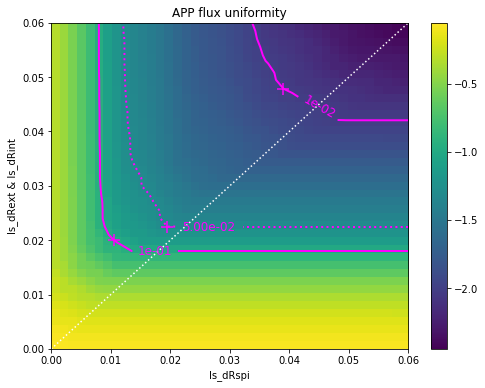

In [27]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_app)

# 2) L-RAVC + classical imaging (field = 6" circular)

In [28]:
band = 'L'
mode = 'RAVC'

## 2.1) IMG plane

In [29]:
plane = 'IMG'
rs_opt = 0.0207#0.0333#0.0317
rp_opt = 0.0207#0.0307#0.0291

### with diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



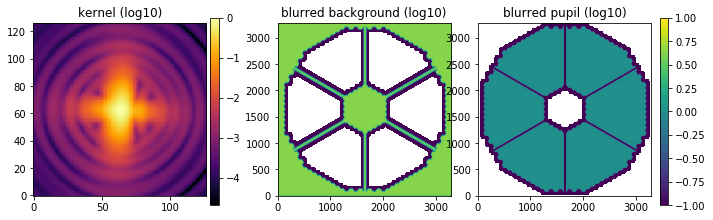

In [30]:
conf = conf_init('IMG_L_field_6_ravc', band, mode)
data = os.path.join(dir_data, 'IMG_VPM_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [31]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 1.31e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (4.95%, 5.65%)
optim 1 = 1e-05 (4.39%, 4.80%)
optim 2 = 1e-04 (3.57%, 3.60%)
optim 3 = 1e-03 (2.27%, 2.25%)
optim 4 = 1.31e-03 (2.10%, 2.03%)
optim 5 = 1e-02 (0.65%, 0.75%)


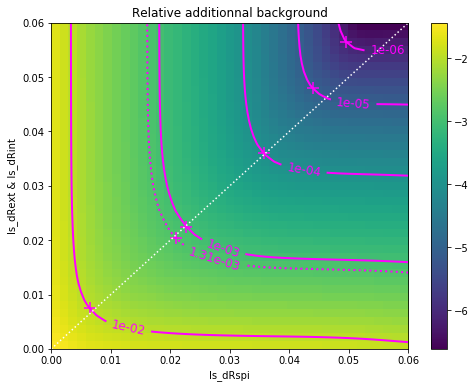

In [32]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 2.75e-02 (2.07%, 2.07%)
optim 0 = 1e-06 (1.01%, 0.00%)
optim 1 = 1e-05 (0.97%, 0.00%)
optim 2 = 1e-04 (0.93%, 0.00%)
optim 3 = 1e-03 (0.85%, 0.00%)
optim 4 = 1e-02 (0.60%, 0.00%)
optim 5 = 2.75e-02 (0.38%, 0.00%)
optim 6 = 1e-01 (0.07%, 0.00%)


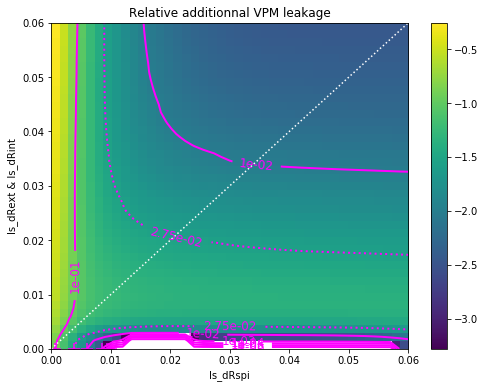

In [33]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 1.44e-03 (2.07%, 2.07%)
optim 0 = 6.68e-04 (0.95%, 6.00%)
optim 1 = 1.05e-03 (0.75%, 3.47%)
optim 2 = 1.44e-03 (0.59%, 2.25%)
optim 3 = 1.65e-03 (0.45%, 1.88%)
optim 4 = 2.59e-03 (0.30%, 0.83%)
optim 5 = 4.07e-03 (0.15%, 0.09%)


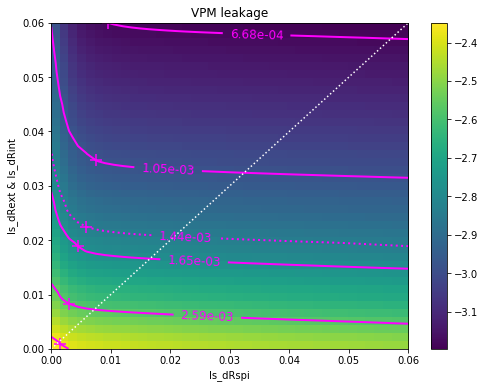

In [34]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 8.33e-03 (2.07%, 2.07%)
optim 0 = 7.11e-03 (0.45%, 1.53%)
optim 1 = 8.33e-03 (0.30%, 0.71%)
optim 2 = 9.45e-03 (0.25%, 0.30%)
optim 3 = 1.26e-02 (0.00%, 5.41%)
optim 4 = 1.67e-02 (4.16%, 0.00%)
optim 5 = 2.21e-02 (5.89%, 0.00%)


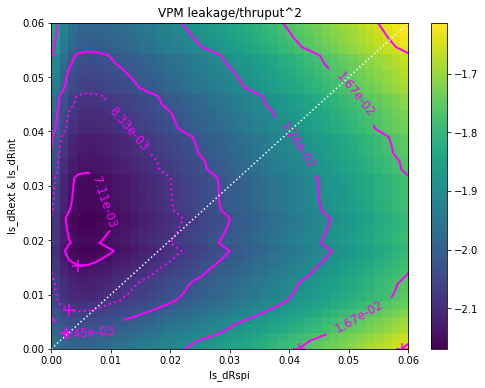

In [35]:
thruput = hci_sharp/np.sum(pup_vpm)*ravc_strehl_flux*ravc_t
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

### no diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



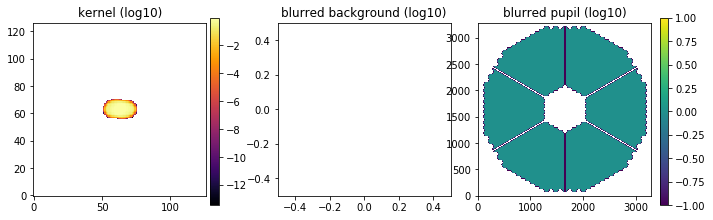

In [36]:
conf = conf_init('IMG_L_field_6_ravc_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [37]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 2.42e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (0.12%, 0.00%)
optim 1 = 1e-05 (0.09%, 0.00%)
optim 2 = 1e-04 (0.07%, 0.00%)
optim 3 = 1e-03 (0.04%, 0.00%)
optim 4 = 2.42e-03 (0.03%, 0.00%)
optim 5 = 1e-02 (0.01%, 0.00%)
optim 6 = 1e-01 (0.00%, 2.57%)


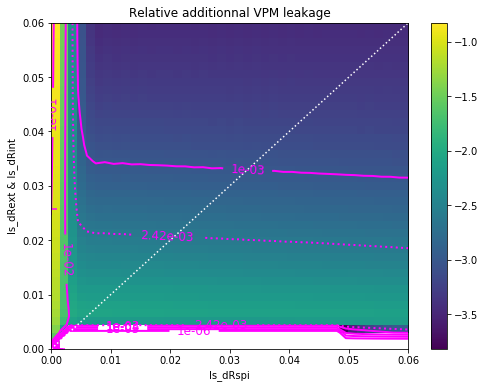

In [38]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 1.41e-03 (2.07%, 2.07%)
optim 0 = 6.66e-04 (0.30%, 5.92%)
optim 1 = 1.02e-03 (0.30%, 3.45%)
optim 2 = 1.41e-03 (0.15%, 2.23%)
optim 3 = 1.57e-03 (0.15%, 1.86%)
optim 4 = 2.41e-03 (0.15%, 0.81%)
optim 5 = 3.69e-03 (0.00%, 0.20%)


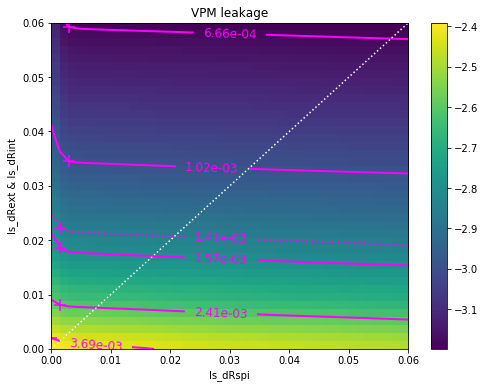

In [39]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 8.13e-03 (2.07%, 2.07%)
optim 0 = 6.48e-03 (0.15%, 1.49%)
optim 1 = 8.13e-03 (0.00%, 0.57%)
optim 2 = 8.80e-03 (0.00%, 0.34%)
optim 3 = 1.20e-02 (1.92%, 0.00%)
optim 4 = 1.62e-02 (4.05%, 0.00%)
optim 5 = 2.21e-02 (5.94%, 0.00%)


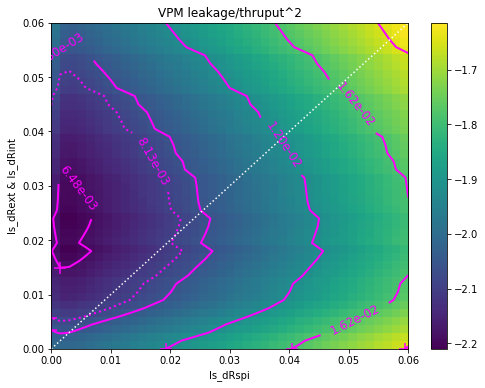

In [40]:
thruput = hci_sharp/np.sum(pup_vpm)*ravc_strehl_flux*ravc_t
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

## 2.2) LMS plane

In [41]:
plane = 'LMS'
rs_opt = 0.0225
rp_opt = 0.0225

### with diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



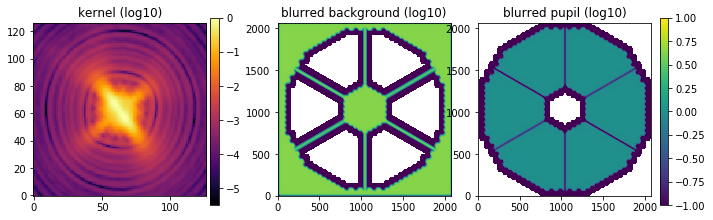

In [42]:
conf = conf_init('LMS_L_field_6_ravc', band, mode)
data = os.path.join(dir_data, 'LMS_VPM_worstcase_pp%s.txt')
data_i = 7
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [43]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 2.93e-03 (2.25%, 2.25%)
optim 0 = 1e-04 (5.92%, 5.70%)
optim 1 = 1e-03 (3.55%, 3.60%)
optim 2 = 2.93e-03 (2.25%, 2.25%)
optim 3 = 1e-02 (1.13%, 1.05%)


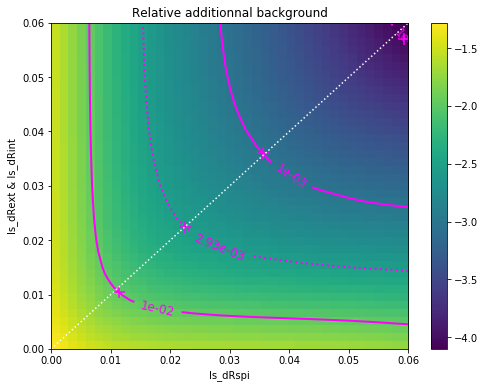

In [44]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 4.84e-02 (2.25%, 2.25%)
optim 0 = 1e-02 (3.75%, 5.43%)
optim 1 = 4.84e-02 (0.57%, 0.00%)
optim 2 = 1e-01 (0.32%, 0.00%)


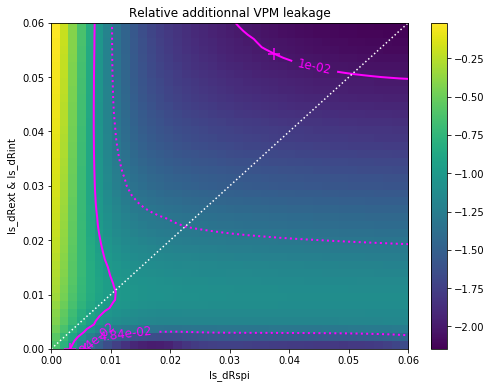

In [45]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 1.38e-03 (2.25%, 2.25%)
optim 0 = 6.73e-04 (1.28%, 6.00%)
optim 1 = 1.09e-03 (0.90%, 3.46%)
optim 2 = 1.38e-03 (0.75%, 2.55%)
optim 3 = 1.75e-03 (0.60%, 1.85%)
optim 4 = 2.82e-03 (0.45%, 0.79%)
optim 5 = 4.54e-03 (0.22%, 0.00%)


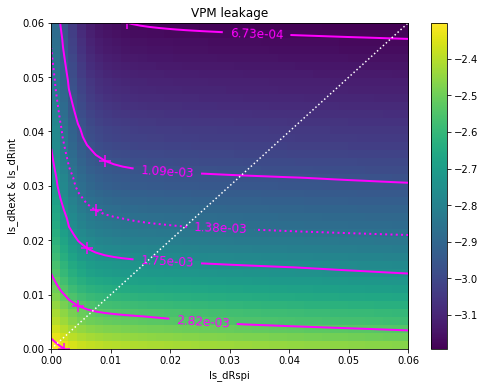

In [46]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 8.91e-03 (2.25%, 2.25%)
optim 0 = 7.86e-03 (0.60%, 1.62%)
optim 1 = 8.91e-03 (0.45%, 0.89%)
optim 2 = 1.03e-02 (0.00%, 1.18%)
optim 3 = 1.35e-02 (0.00%, 4.39%)
optim 4 = 1.76e-02 (4.06%, 0.00%)
optim 5 = 2.31e-02 (5.71%, 0.00%)


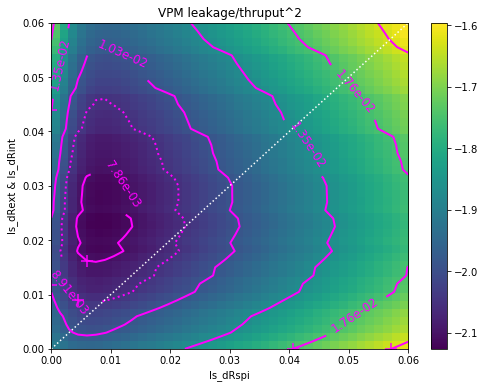

In [47]:
thruput = hci_sharp/np.sum(pup_vpm)*ravc_strehl_flux*ravc_t
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

### no diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



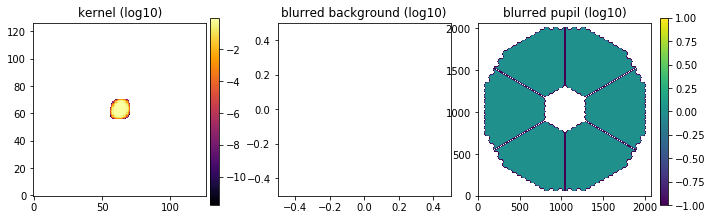

In [48]:
conf = conf_init('LMS_L_field_6_ravc_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/LMS_3_worstcase_pp%s.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [49]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 3.13e-03 (2.25%, 2.25%)
optim 0 = 1e-06 (0.12%, 0.00%)
optim 1 = 1e-05 (0.10%, 0.00%)
optim 2 = 1e-04 (0.07%, 0.00%)
optim 3 = 1e-03 (0.04%, 0.00%)
optim 4 = 3.13e-03 (0.03%, 0.00%)
optim 5 = 1e-02 (0.02%, 0.00%)
optim 6 = 1e-01 (0.00%, 0.77%)


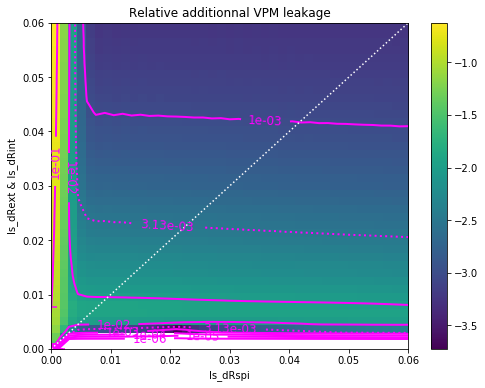

In [50]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 1.32e-03 (2.25%, 2.25%)
optim 0 = 6.69e-04 (0.30%, 5.96%)
optim 1 = 1.03e-03 (0.30%, 3.45%)
optim 2 = 1.32e-03 (0.30%, 2.42%)
optim 3 = 1.60e-03 (0.30%, 1.77%)
optim 4 = 2.47e-03 (0.15%, 0.82%)
optim 5 = 3.81e-03 (0.00%, 0.15%)


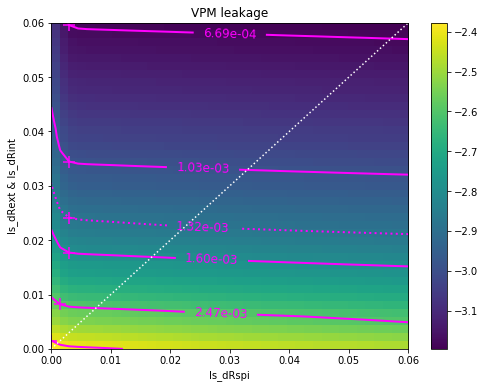

In [51]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 8.53e-03 (2.25%, 2.25%)
optim 0 = 6.75e-03 (0.15%, 1.62%)
optim 1 = 8.53e-03 (0.15%, 0.50%)
optim 2 = 9.16e-03 (0.06%, 0.30%)
optim 3 = 1.24e-02 (1.87%, 0.00%)
optim 4 = 1.69e-02 (4.00%, 0.00%)
optim 5 = 2.29e-02 (5.88%, 0.00%)


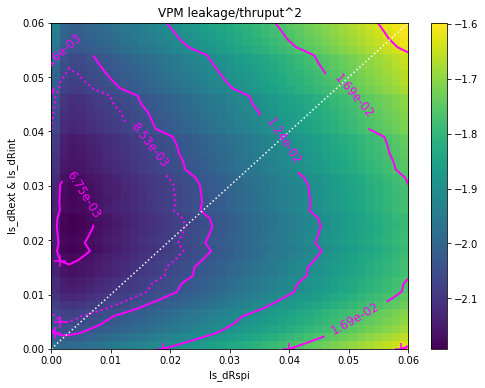

In [52]:
thruput = hci_sharp/np.sum(pup_vpm)*ravc_strehl_flux*ravc_t
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

# 3) L-CVC (field = 6" circular)

In [53]:
band = 'L'
mode = 'CVC'

## 3.1) IMG plane

In [54]:
plane = 'IMG'
rs_opt = 0.0207#0.0333#0.0317
rp_opt = 0.0207#0.0307#0.0291

### with diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



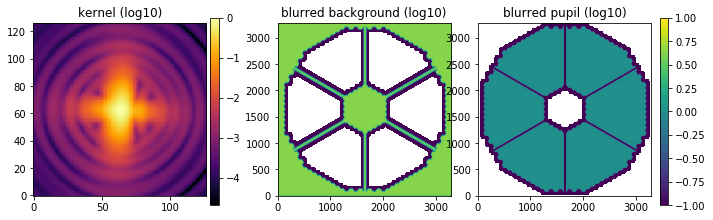

In [55]:
conf = conf_init('IMG_L_field_6_cvc', band, mode)
data = os.path.join(dir_data, 'IMG_VPM_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [56]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 4.61e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (1.01%, 0.00%)
optim 1 = 1e-05 (0.98%, 0.00%)
optim 2 = 1e-04 (0.94%, 0.00%)
optim 3 = 1e-03 (0.91%, 0.00%)
optim 4 = 4.61e-03 (0.73%, 0.00%)
optim 5 = 1e-02 (0.54%, 0.00%)


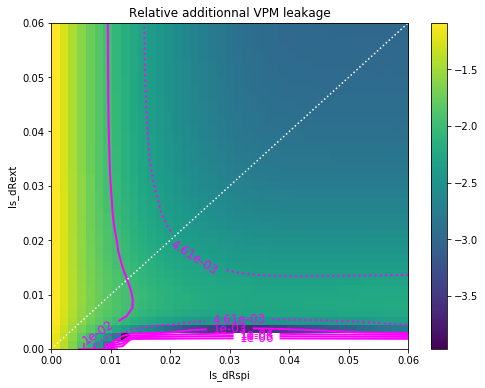

In [57]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.66e-02 (2.07%, 2.07%)
optim 0 = 2.20e-02 (6.00%, 2.61%)
optim 1 = 2.41e-02 (4.73%, 1.65%)
optim 2 = 2.63e-02 (2.45%, 1.95%)
optim 3 = 2.66e-02 (2.24%, 1.80%)
optim 4 = 2.88e-02 (0.75%, 1.44%)
optim 5 = 3.15e-02 (0.38%, 0.45%)


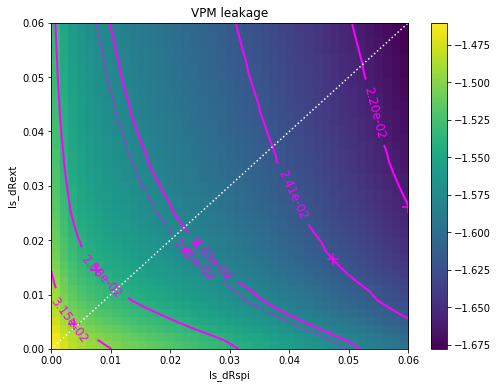

In [58]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 5.41e-02 (2.07%, 2.07%)
optim 0 = 3.86e-02 (0.00%, 0.89%)
optim 1 = 5.41e-02 (3.12%, 0.00%)
optim 2 = 5.50e-02 (0.00%, 4.00%)
optim 3 = 7.84e-02 (5.36%, 0.00%)
optim 4 = 1.12e-01 (3.75%, 5.55%)
optim 5 = 1.59e-01 (5.77%, 5.55%)


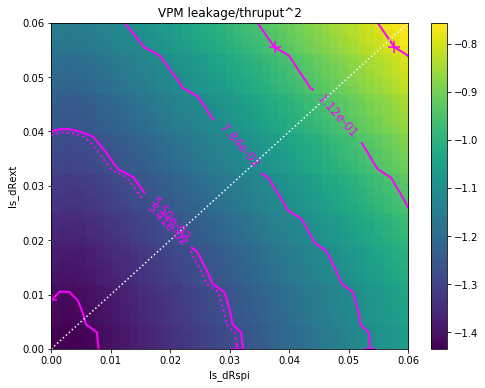

In [59]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

### no diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



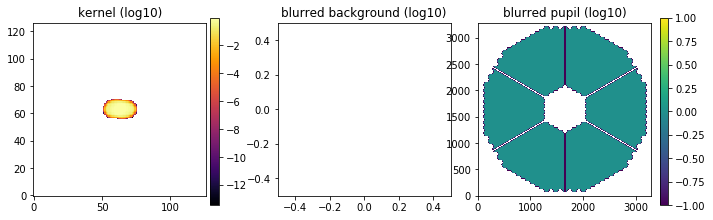

In [60]:
conf = conf_init('IMG_L_field_6_cvc_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [61]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 2.97e-04 (2.07%, 2.07%)
optim 0 = 1e-06 (0.27%, 0.00%)
optim 1 = 1e-05 (0.23%, 0.00%)
optim 2 = 1e-04 (0.20%, 0.00%)
optim 3 = 2.97e-04 (0.18%, 0.00%)
optim 4 = 1e-03 (0.16%, 0.00%)
optim 5 = 1e-02 (0.03%, 0.00%)


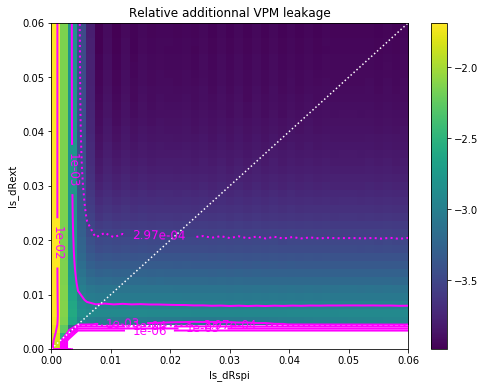

In [62]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.65e-02 (2.07%, 2.07%)
optim 0 = 2.20e-02 (6.00%, 2.55%)
optim 1 = 2.38e-02 (4.92%, 1.65%)
optim 2 = 2.57e-02 (3.04%, 1.80%)
optim 3 = 2.65e-02 (2.24%, 1.80%)
optim 4 = 2.78e-02 (0.70%, 2.10%)
optim 5 = 3.00e-02 (0.15%, 0.82%)


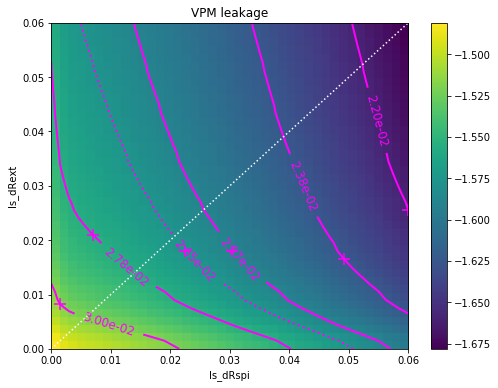

In [63]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 5.39e-02 (2.07%, 2.07%)
optim 0 = 3.71e-02 (0.57%, 0.00%)
optim 1 = 5.34e-02 (3.02%, 0.00%)
optim 2 = 5.39e-02 (3.08%, 0.00%)
optim 3 = 7.69e-02 (5.24%, 0.00%)
optim 4 = 1.11e-01 (3.70%, 5.55%)
optim 5 = 1.59e-01 (5.77%, 5.55%)


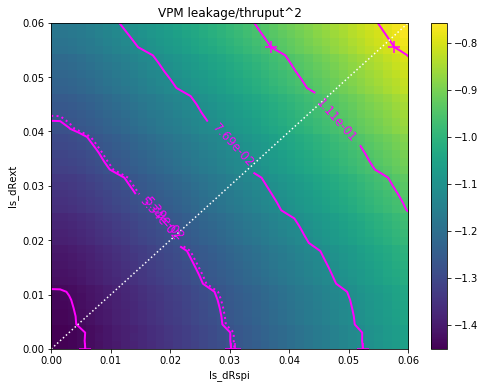

In [64]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

## 3.2) LMS plane

In [65]:
plane = 'LMS'
rs_opt = 0.0225
rp_opt = 0.0225

### with diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



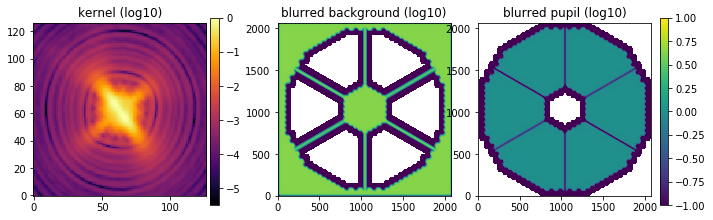

In [66]:
conf = conf_init('LMS_L_field_6_cvc', band, mode)
data = os.path.join(dir_data, 'LMS_VPM_worstcase_pp%s.txt')
data_i = 7
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [67]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 8.81e-03 (2.25%, 2.25%)
optim 0 = 1e-06 (1.60%, 0.00%)
optim 1 = 1e-05 (1.56%, 0.00%)
optim 2 = 1e-04 (1.51%, 0.00%)
optim 3 = 1e-03 (1.38%, 0.00%)
optim 4 = 8.81e-03 (0.92%, 0.00%)
optim 5 = 1e-02 (0.88%, 0.00%)
optim 6 = 1e-01 (0.02%, 0.00%)


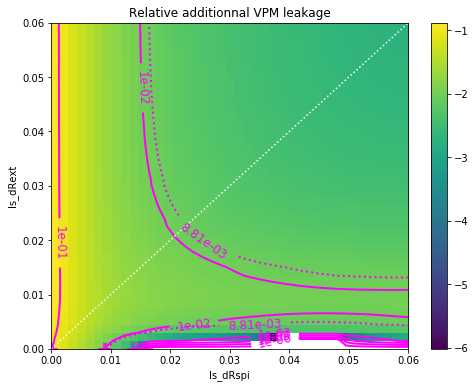

In [68]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.64e-02 (2.25%, 2.25%)
optim 0 = 2.21e-02 (6.00%, 2.65%)
optim 1 = 2.44e-02 (4.35%, 1.95%)
optim 2 = 2.64e-02 (2.48%, 1.95%)
optim 3 = 2.69e-02 (2.10%, 1.87%)
optim 4 = 2.97e-02 (0.79%, 1.05%)
optim 5 = 3.28e-02 (0.45%, 0.13%)


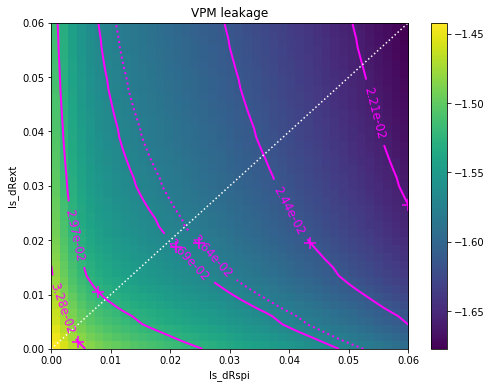

In [69]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 5.89e-02 (2.25%, 2.25%)
optim 0 = 4.12e-02 (0.00%, 0.52%)
optim 1 = 5.83e-02 (0.00%, 3.91%)
optim 2 = 5.89e-02 (0.00%, 3.95%)
optim 3 = 8.25e-02 (5.43%, 0.00%)
optim 4 = 1.17e-01 (3.69%, 5.70%)
optim 5 = 1.65e-01 (5.67%, 5.70%)


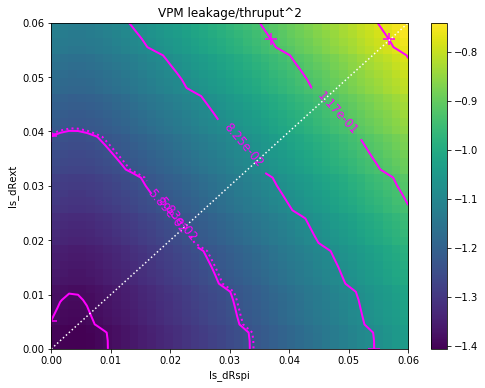

In [70]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

### no diffraction

background:
   nkernel = 127, npup_conv = 2071
HCI:
   nkernel_vpm = 69, npup_vpm = 1141



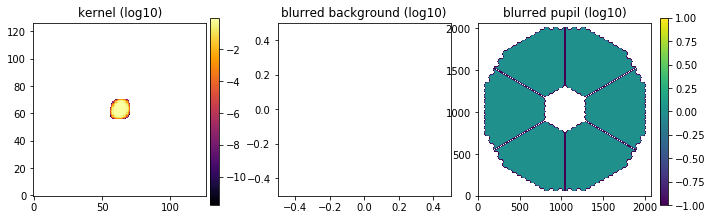

In [71]:
conf = conf_init('LMS_L_field_6_cvc_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/LMS_3_worstcase_pp%s.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [72]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 3.97e-04 (2.25%, 2.25%)
optim 0 = 1e-06 (0.27%, 0.00%)
optim 1 = 1e-05 (0.24%, 0.00%)
optim 2 = 1e-04 (0.20%, 0.00%)
optim 3 = 3.97e-04 (0.18%, 0.00%)
optim 4 = 1e-03 (0.17%, 0.00%)
optim 5 = 1e-02 (0.07%, 0.00%)


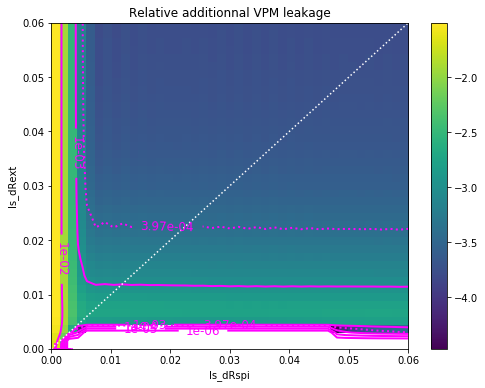

In [73]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.62e-02 (2.25%, 2.25%)
optim 0 = 2.20e-02 (6.00%, 2.56%)
optim 1 = 2.39e-02 (4.89%, 1.65%)
optim 2 = 2.59e-02 (2.93%, 1.80%)
optim 3 = 2.62e-02 (2.47%, 1.95%)
optim 4 = 2.80e-02 (0.58%, 1.95%)
optim 5 = 3.04e-02 (0.18%, 0.75%)


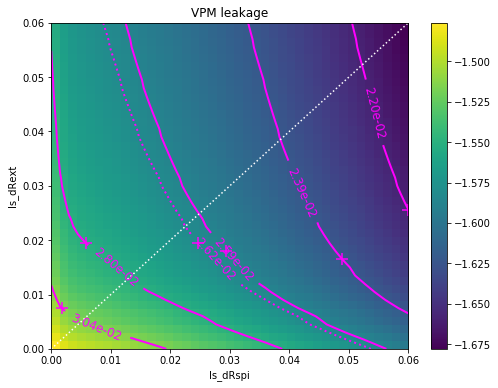

In [74]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 5.84e-02 (2.25%, 2.25%)
optim 0 = 3.87e-02 (0.61%, 0.00%)
optim 1 = 5.55e-02 (3.04%, 0.00%)
optim 2 = 5.84e-02 (3.36%, 0.00%)
optim 3 = 7.98e-02 (5.25%, 0.00%)
optim 4 = 1.15e-01 (3.61%, 5.70%)
optim 5 = 1.65e-01 (5.67%, 5.70%)


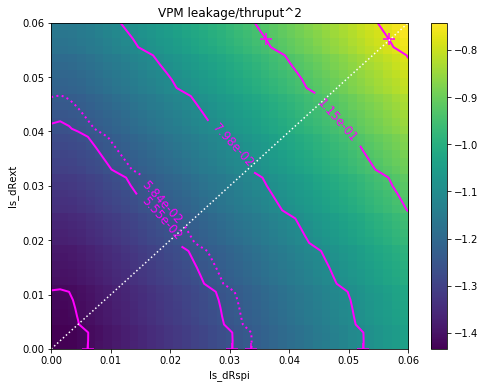

In [75]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

# 4) N-CVC + classical imaging (field = 14")

In [76]:
rs_opt = 0.0519#0.0645
rp_opt = 0.0519#0.0619
band = 'N2'
mode = 'CVC'
plane = 'IMG'

### with diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 19, npup_vpm = 493



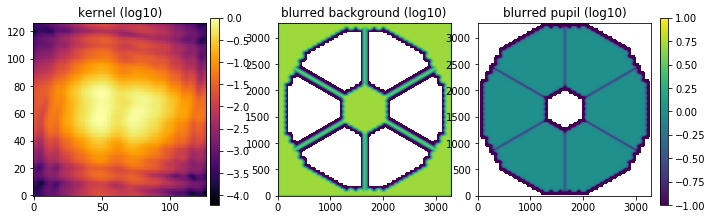

In [77]:
conf = conf_init('IMG_N_field_14_cvc', band, mode)
data = os.path.join(dir_data, 'IMG_14_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [78]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 2.83e-06 (5.19%, 5.19%)
optim 0 = 1e-06 (4.80%, 5.59%)
optim 1 = 2.83e-06 (4.52%, 5.40%)
optim 2 = 1e-05 (4.33%, 4.95%)
optim 3 = 1e-04 (3.75%, 4.03%)
optim 4 = 1e-03 (3.00%, 2.97%)
optim 5 = 1e-02 (1.80%, 1.63%)


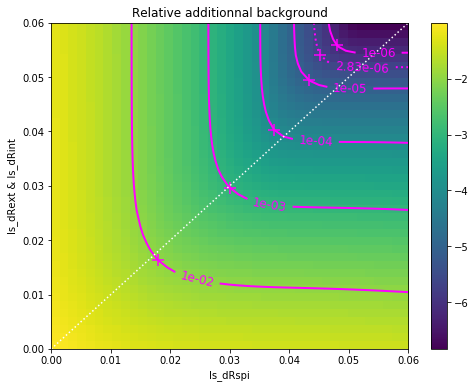

In [79]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_bkg)

intersect = 3.97e-03 (5.19%, 5.19%)
optim 0 = 3.97e-03 (4.00%, 5.40%)
optim 1 = 1e-02 (2.51%, 0.00%)
optim 2 = 1e-01 (0.55%, 0.00%)


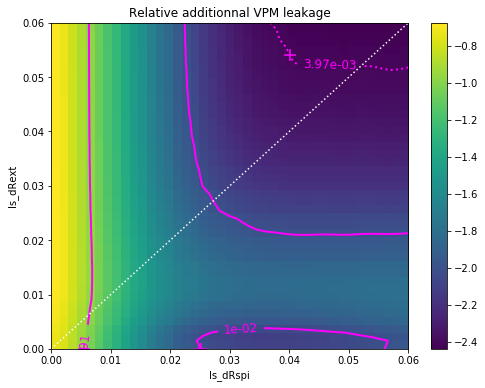

In [80]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.22e-02 (5.19%, 5.19%)
optim 0 = 2.22e-02 (6.00%, 2.78%)
optim 1 = 2.22e-02 (6.00%, 2.58%)
optim 2 = 2.49e-02 (3.91%, 2.10%)
optim 3 = 2.80e-02 (2.00%, 1.35%)
optim 4 = 3.15e-02 (1.20%, 0.35%)
optim 5 = 3.53e-02 (0.47%, 0.00%)


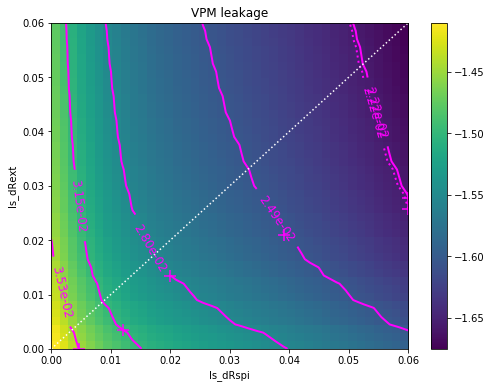

In [81]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 1.70e-01 (5.19%, 5.19%)
optim 0 = 5.32e-02 (0.00%, 0.37%)
optim 1 = 7.41e-02 (0.00%, 3.55%)
optim 2 = 1.03e-01 (5.63%, 0.00%)
optim 3 = 1.44e-01 (3.90%, 5.55%)
optim 4 = 1.70e-01 (4.85%, 5.55%)
optim 5 = 2.01e-01 (5.79%, 5.55%)


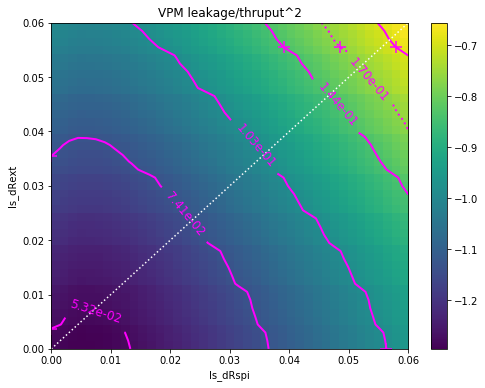

In [82]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)

### no diffraction

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 19, npup_vpm = 493



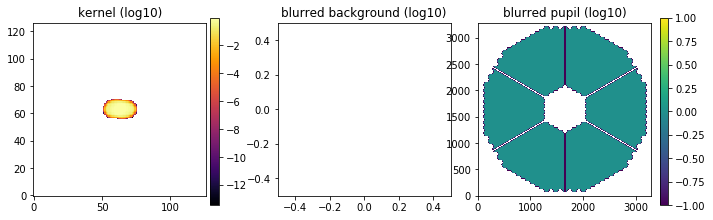

In [83]:
conf = conf_init('IMG_N_field_14_cvc_no_diffract', band, mode)
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, plane, data, data_i)

In [84]:
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, 
    data_i, rs, rp, plane=plane)

intersect = 2.01e-04 (5.19%, 5.19%)
optim 0 = 1e-06 (0.42%, 0.00%)
optim 1 = 1e-05 (0.38%, 0.00%)
optim 2 = 1e-04 (0.35%, 0.00%)
optim 3 = 2.01e-04 (0.34%, 0.00%)
optim 4 = 1e-03 (0.31%, 0.00%)
optim 5 = 1e-02 (0.11%, 0.00%)


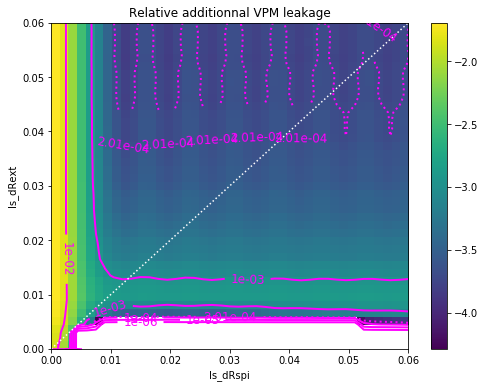

In [85]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm)

intersect = 2.22e-02 (5.19%, 5.19%)
optim 0 = 2.21e-02 (6.00%, 2.54%)
optim 1 = 2.22e-02 (6.00%, 2.46%)
optim 2 = 2.39e-02 (5.08%, 1.50%)
optim 3 = 2.59e-02 (3.00%, 1.87%)
optim 4 = 2.80e-02 (0.84%, 1.95%)
optim 5 = 3.03e-02 (0.30%, 0.81%)


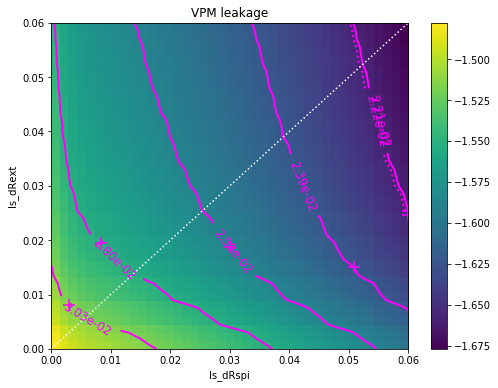

In [86]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm2)

intersect = 1.69e-01 (5.19%, 5.19%)
optim 0 = 4.67e-02 (0.67%, 0.00%)
optim 1 = 6.72e-02 (3.11%, 0.00%)
optim 2 = 9.66e-02 (5.31%, 0.00%)
optim 3 = 1.39e-01 (3.72%, 5.55%)
optim 4 = 1.69e-01 (4.85%, 5.55%)
optim 5 = 2.00e-01 (5.79%, 5.55%)


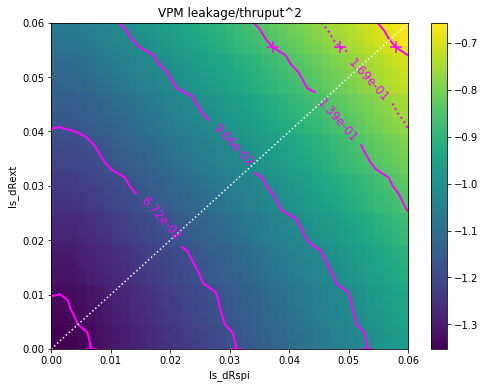

In [87]:
thruput = hci_sharp/np.sum(pup_vpm)*cvc_strehl_flux
plot_2d_map(conf, I_blur/thruput**2, hci_sharp, data_i, rs, rp, rs_opt, rp_opt, title=title_vpm3)